## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

## Warp/Perspective Transforms

Firstly, we shall use camera calibration doe as from sample repo: 
https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb

This will fix the warping

In [3]:
# do camera calibration as from sample repo
# https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


#cv2.destroyAllWindows()

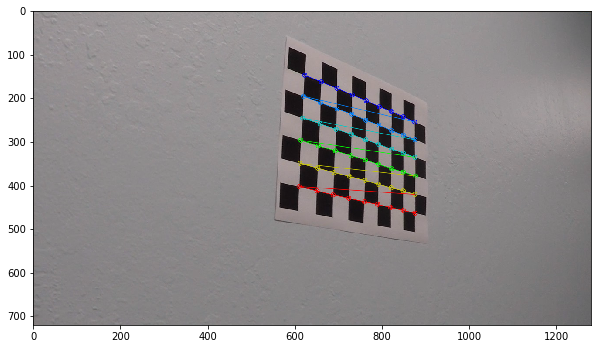

In [4]:
#' Draw and display the corners
img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
plt.imshow(img)

In [5]:
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# based on "Correcting for Distortion" Udacity vid
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

def undistort_image(image):    
    return cv2.undistort(image, mtx, dist, None, mtx)

undistort_img = undistort_image(img)

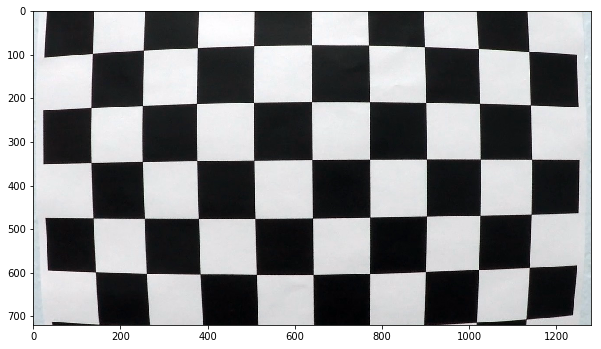

In [6]:
plt.imshow(img)

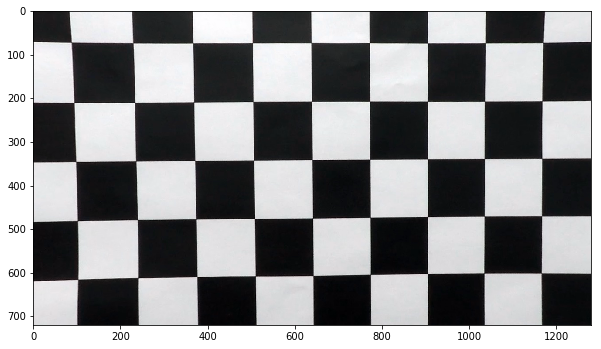

In [7]:
plt.imshow(undistort_img)

(720, 1280, 3)


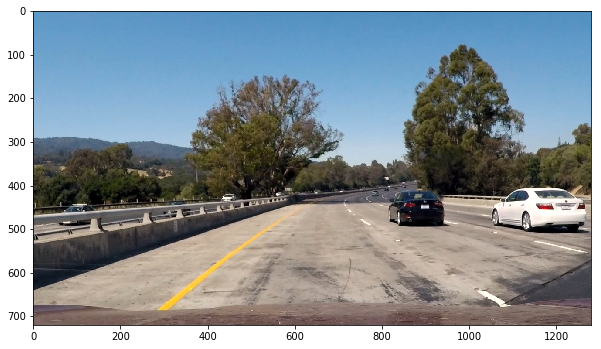

In [8]:
# testing this
test_img = undistort_image(mpimg.imread('test_images/test1.jpg'))
print(test_img.shape)
plt.imshow(mpimg.imread('test_images/test1.jpg'))

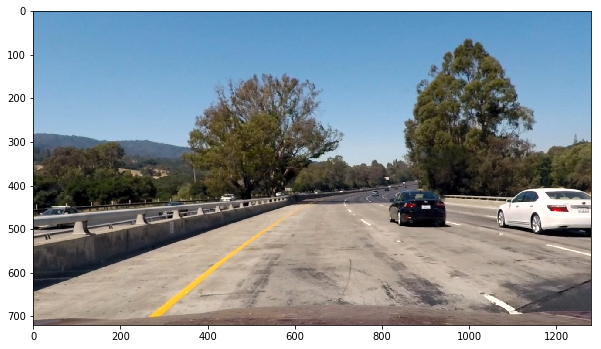

In [9]:
plt.imshow(test_img)

## Perspective Transform

We will use the example function that was in `examples/example.py`

In [10]:
# fixing perspective.

def get_src_dst(img):
    width, height = img.shape[1], img.shape[0]
    off_center = 0
    scale_factor = 460
    offset_top=60
    offset_bottom=450

    offset_top_dst = 300
    offset_bottom_dst = 350

    src = np.float32([
        [(width*0.5) - offset_top, scale_factor], 
        [(width*0.5) + offset_top, scale_factor], 
        [(width*0.5) + offset_bottom, height], 
        [(width*0.5) - offset_bottom, height]])
    dst = np.float32([           
        [(width*0.5) - offset_bottom_dst, max((height*0.5) - scale_factor, 0.0)], 
        [(width*0.5) + offset_top_dst, max((height*0.5) - scale_factor, 0.0)], 
        [(width*0.5) + offset_top_dst + off_center, height], 
        [(width*0.5) - offset_bottom_dst + off_center, height]
    ])
    
    # default from writeup template
    """
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    """
    
    # use this to show measurements
    #print(np.array2string(src, separator=',', precision=2))
    #print(np.array2string(dst, separator=',', precision=2))
    return src, dst


def warper(img, src= None, dst=None, inv=False):
    # from example file: https://github.com/chappers/CarND-Advanced-Lane-Lines/blob/master/examples/example.py
    # Compute and apply perpective transform    
    
    img_size = (img.shape[1], img.shape[0])
    
    if src is None or dst is None:
        src, dst = get_src_dst(img)
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped


In [11]:
def unwarp_inverse_matrix(base_img):
    """
    returns inverse transform
    """
    src, dst = get_src_dst(img)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return Minv

(720, 1280, 3)


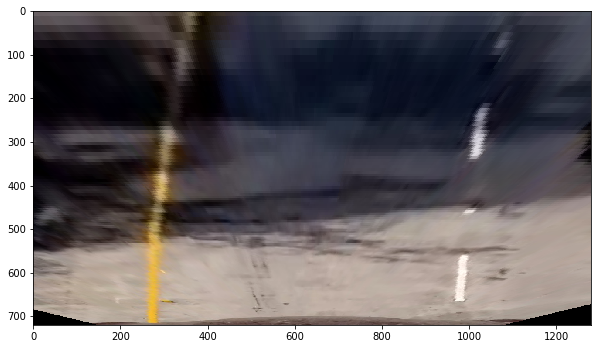

In [12]:
test_img = warper(undistort_image(mpimg.imread('test_images/test5.jpg')), None, None)
print(test_img.shape)
plt.imshow(test_img)

(720, 1280, 3)


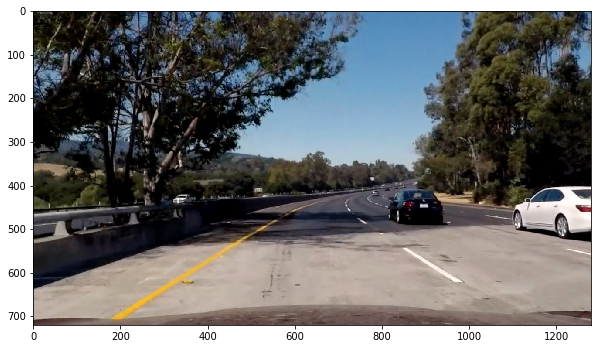

In [13]:
test_img = undistort_image(mpimg.imread('test_images/test5.jpg'))
print(test_img.shape)
plt.imshow(test_img)

(720, 1280, 3)


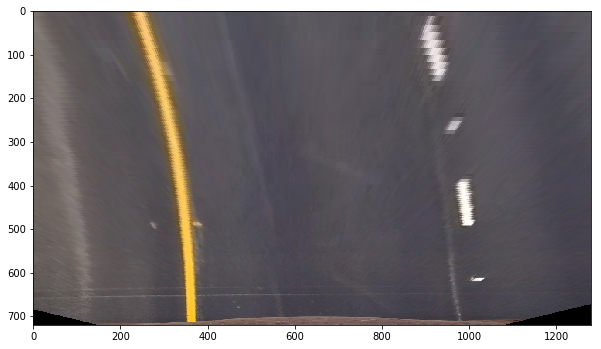

In [14]:
test_img = warper(undistort_image(mpimg.imread('test_images/test2.jpg')))
print(test_img.shape)
plt.imshow(test_img)

## Pipeline Stuff

** Sobel Pipeline **

As shown in the videos and tutorials - only difference is we first convert all yellows to whites (as shown in project 1)

** Threshold **

We take an ensembling approach...Compute all combinations of the following and take the median:

*  R and S Channel
*  histogram equalization and adaptive histogram correction (as shown in traffic sign project)



In [15]:
def yellow_to_white(img1):
    """
    transforms/masks yellow to white...
    """
    img = img1.copy()
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
        keep_mask_color = (0,) * channel_count
    else:
        ignore_mask_color = 255
        keep_mask_color = 0
    
    # yellow mask
    y_lwr = np.array([190, 190, 0])
    y_upr = np.array([255, 255, 160])
    yellow_mask = cv2.inRange(img, y_lwr, y_upr)
    
    img[yellow_mask > 0] = ignore_mask_color
    
    # dark mask... mask
    w_lwr = np.array([0, 0, 200])
    w_upr = np.array([125, 125, 255])
    white_mask = cv2.inRange(img, w_lwr, w_upr)    
    
    img[white_mask > 0] = keep_mask_color
    
    return img.copy()

In [16]:
def col_equalise(img):
    # equalize histograms
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    # split by channel
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

def color_correction(img1, median_blur=5):
    img = img1.copy()
    if median_blur:
        img = cv2.medianBlur(img, median_blur)
    img = col_equalise(img)
    img = yellow_to_white(img)
    ###img = red_to_black(img) # removed...
    return img

In [17]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    thresh_min, thresh_max = thresh
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    except:
        gray = img.copy()
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, magnitude_thresh=(0, 255)):
    # Convert to grayscale
    thresh_min, thresh_max = magnitude_thresh
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


In [18]:
def abs_sobel_thresh_single(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # same as above for single channel case
    thresh_min, thresh_max = thresh
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    #binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return scaled_sobel

In [19]:
def threshold_pipeline(image, thresh=245):
    """
    This pipeline is based on using only R and S channels
    (see HLS and Color Thresholds)
    """
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    def equalise(img, mode='CLAHE'):
        """single channel image"""        
        if mode == 'CLAHE':
            img = clahe.apply(img)
        else:
            img = cv2.equalizeHist(img)
        #img = cv2.medianBlur(img, 5)
        return img
        
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    R = image[:,:,0]
    S = hls[:,:,2]
    
    # then equalise...
    R_c = equalise(R, mode='CLAHE')
    S_c = equalise(S, mode='CLAHE')
    
    R_hist = equalise(R, mode='hist')
    S_hist = equalise(S, mode='hist')
    
    RS = np.median([R_c, S_c, R_hist, S_hist], axis=0)
    RS = np.median([R_c, R_hist], axis=0)
    RS[RS < thresh] = 0
    RS[RS >= thresh] = 1
    return RS

    

In [20]:
def sobel_pipeline(image, sobel_kernel=3, 
                   gradx_thresh=(0, 255), 
                   grady_thresh=(0, 255), 
                   magnitude_thresh=(0, 255), 
                   dir_thresh=(0, np.pi/2)):
    image = yellow_to_white(image)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply each of the thresholding functions
    # initialize
    gradx = np.ones_like(gray)
    grady = np.ones_like(gray)
    mag_binary = np.zeros_like(gray)
    dir_binary = np.zeros_like(gray)
    
    if gradx_thresh:
        gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=sobel_kernel, thresh=gradx_thresh)
        combined = np.zeros_like(gradx)
       
    if grady_thresh:
        grady = abs_sobel_thresh(image, orient='y', sobel_kernel=sobel_kernel, thresh=grady_thresh)
        combined = np.zeros_like(grady)
        
    if magnitude_thresh:
        mag_binary = mag_thresh(image, sobel_kernel=sobel_kernel, magnitude_thresh=magnitude_thresh)
        combined = np.zeros_like(mag_binary)
        
    if dir_thresh:
        dir_binary = dir_threshold(image, sobel_kernel=sobel_kernel, thresh=dir_thresh)
        combined = np.zeros_like(dir_binary)
    
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

In [21]:
def threshold_pipeline(image, thresh=250):
    R = image[:,:,0]
    R_hist = cv2.equalizeHist(R)
    R_hist[R_hist < thresh] = 0
    R_hist[R_hist >= thresh] = 1
    return R_hist   

In [22]:
def combined_pipeline(image, 
                      sobel_config={"sobel_kernel"     : 5, 
                        "gradx_thresh"     : (30, 255), 
                        "grady_thresh"     : (30, 255), 
                        "magnitude_thresh" : (50, 100), 
                        "dir_thresh"       : (0.7, 1.3)}, 
                      thres_config={'thresh': 250}):
    #sobel_config['image'] = yellow_to_white(image)
    #thres_config['image'] = image
    sobel_img = sobel_pipeline(image=image, **sobel_config)
    thres_img = threshold_pipeline(image=image, **thres_config)
    
    combined = np.zeros_like(sobel_img)
    combined[(sobel_img==1) | (thres_img==1)] = 1
    return thres_img

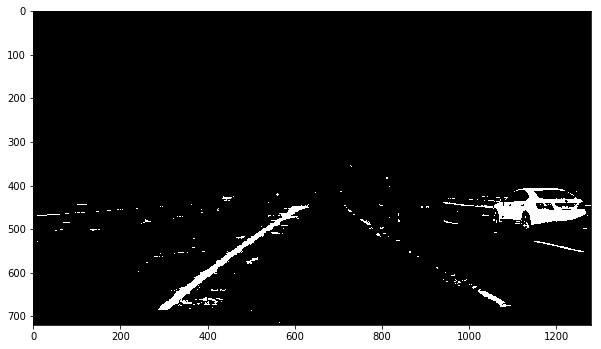

In [23]:
img = mpimg.imread('test_images/test1.jpg')
R = combined_pipeline(img)
plt.imshow(R, cmap='gray')

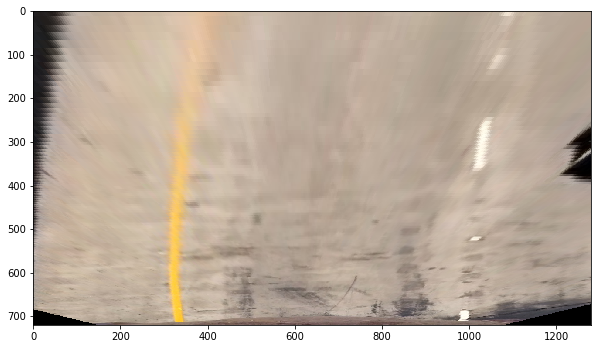

In [24]:
test_img = warper(undistort_image(mpimg.imread('test_images/test1.jpg')))
plt.imshow(test_img)

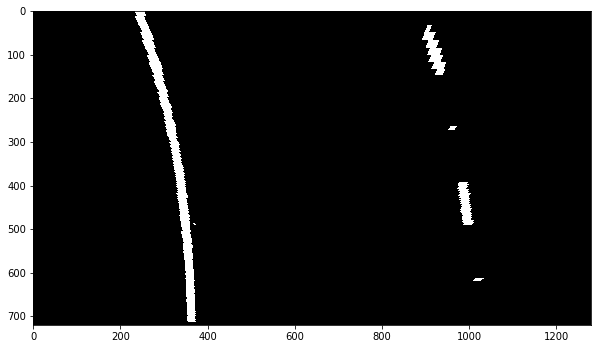

In [25]:
test_img = combined_pipeline(warper(undistort_image(mpimg.imread('test_images/test2.jpg'))))
plt.imshow(test_img, cmap='gray')

## Lane Detection

We will use the histogram approach for the lane detection

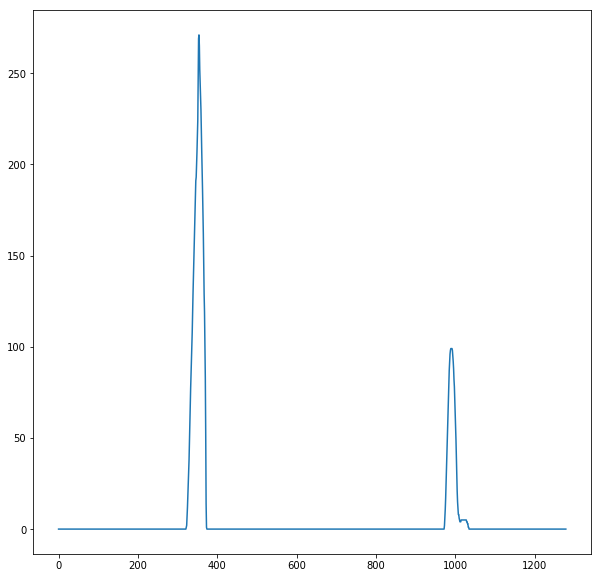

In [26]:
import numpy as np
img = combined_pipeline(warper(undistort_image(mpimg.imread('test_images/test2.jpg'))))
histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [27]:
binary_warped = combined_pipeline(warper(undistort_image(mpimg.imread('test_images/test2.jpg'))))
# code from finding the lines

import numpy as np
import cv2
import matplotlib.pyplot as plt

def get_poly_info(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2.0):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # make sure it doesn't come too close to the center either
        win_xleft_high = min(leftx_current + margin, 640-margin)
        win_xleft_low = min(leftx_current - margin, win_xleft_high-margin)
        
        win_xright_low = max(rightx_current - margin, 640+margin)
        win_xright_high = max(rightx_current + margin, win_xright_low+margin)
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    

    # Fit a second order polynomial to each
    # lets use scikit learn instead?
    left_fit_poly = np.polyfit(lefty, leftx, 2)
    right_fit_poly = np.polyfit(righty, rightx, 2)
    
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures
    
    poly = PolynomialFeatures()
    left_mod = LinearRegression()
    right_mod = LinearRegression()
    
    lefty_poly = poly.fit_transform(lefty.reshape(-1, 1))
    righty_poly = poly.fit_transform(righty.reshape(-1, 1))
    
    left_fit = left_mod.fit(lefty_poly, leftx)
    right_fit = right_mod.fit(righty_poly, rightx)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    ploty_poly = poly.fit_transform(ploty.reshape(-1, 1))
    left_fitx = left_fit.predict(ploty_poly)
    right_fitx = right_fit.predict(ploty_poly)
    return left_fitx, right_fitx, ploty, lefty, righty, leftx, rightx, left_fit_poly, right_fit_poly

In [28]:
# Generate x and y values for plotting

def draw_poly_debug(left_fitx, right_fitx, ploty, lefty, righty, leftx, rightx):
    plt.plot(left_fitx, ploty, color='red')
    plt.plot(right_fitx, ploty, color='blue')
    plt.plot(leftx, lefty, 'ro', alpha=0.2)
    plt.plot(rightx, righty, 'bo', alpha=0.2)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()

In [29]:
def draw_curvature(left_fit, right_fit, ploty, leftx, rightx):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
        
    # calculate off centerness
    # img dim is 720*1280 - so mid point is 1280/2  = 640
    # then dist from middle is
    left_dev = abs(640.0-leftx[-1])
    right_dev = abs(640.0-rightx[-1])
    num_meters_dev = "{0:.2f}".format(abs(left_dev-right_dev)*xm_per_pix)
    text_dev = 'right' if left_dev > right_dev else 'left'    
    
    radius_of_curvature = np.mean([left_curverad, right_curverad])
    
    curve_text = "Radius of Curvature = {0:.2f}m".format(radius_of_curvature)
    center_text = "Vehicle is {}m {} of center".format(num_meters_dev, text_dev)
    
    #print(curve_text)
    #print(center_text)
    
    return curve_text, center_text

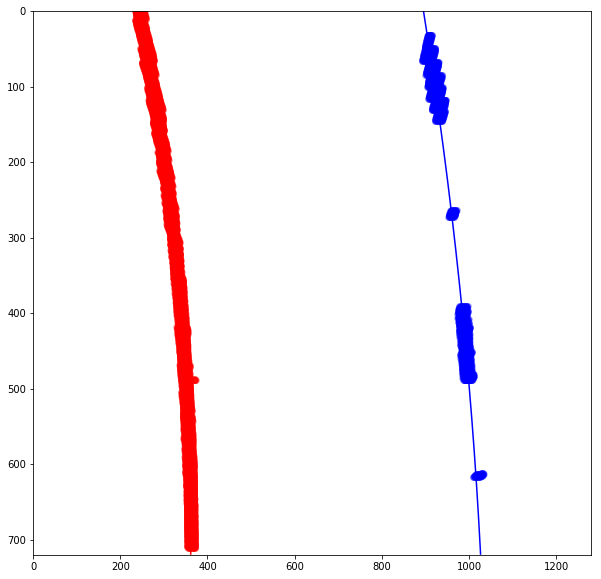

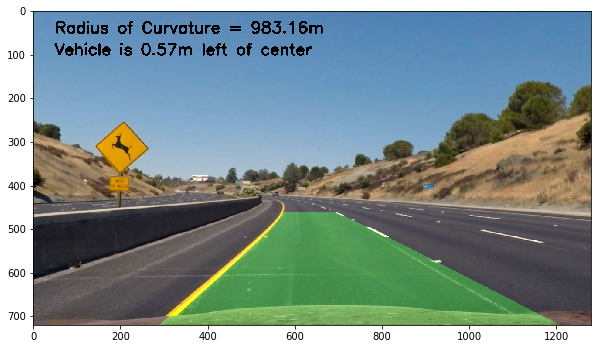

In [30]:
# draw on the road
# assumes we have...leftfitx, rightfitx, ploty


def draw_poly_text(undist, warped, left_fitx, right_fitx, ploty, curve_text, center_text):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = unwarp_inverse_matrix(undist)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # add text...
    
    cv2.putText(result, curve_text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, 0, 3)
    cv2.putText(result, center_text, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.2, 0, 3)
    
    return result

base_img = mpimg.imread('test_images/test2.jpg')
undist = undistort_image(base_img)
warped = combined_pipeline(warper(undistort_image(base_img)))
left_fitx, right_fitx, ploty, lefty, righty, leftx, rightx, left_fit, right_fit = get_poly_info(warped)

curve_text, center_text = draw_curvature(left_fit, right_fit, ploty, left_fitx, right_fitx)

draw_poly_debug(left_fitx, right_fitx, ploty, lefty, righty, leftx, rightx)
result = draw_poly_text(undist, warped, left_fitx, right_fitx, ploty, curve_text, center_text)
plt.imshow(result)

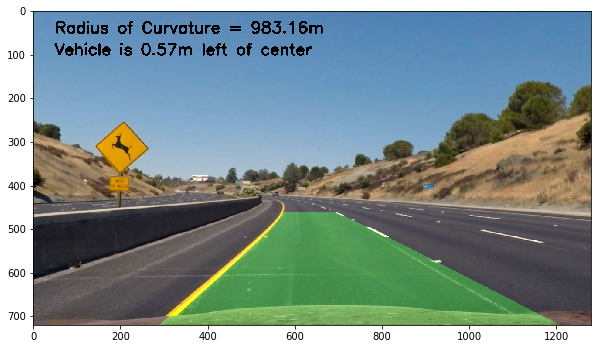

In [31]:
# lets try to do the video...

def draw_full_pipeline(base_img):
    undist = undistort_image(base_img)
    warped = combined_pipeline(warper(undistort_image(base_img)))
    left_fitx, right_fitx, ploty, lefty, righty, leftx, rightx, left_fit, right_fit = get_poly_info(warped)
    
    curve_text, center_text = draw_curvature(left_fit, right_fit, ploty, left_fitx, right_fitx)
    #draw_poly_debug(left_fitx, right_fitx, ploty)
    result = draw_poly_text(undist, warped, left_fitx, right_fitx, ploty, curve_text, center_text)    
    
    return result

base_img = mpimg.imread('test_images/test2.jpg')
plt.imshow(draw_full_pipeline(base_img))

In [32]:
import os

In [33]:
all_f = glob.glob("./test_images/*.jpg")
for img_file in all_f:
    base_img = mpimg.imread(img_file)
    result = draw_full_pipeline(base_img)
    cv2.imwrite(os.path.join("output_images", os.path.basename(img_file)), cv2.cvtColor(result, cv2.COLOR_RGB2BGR))

In [34]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [35]:
# try for the video...
# we have not implemented convolution solution - might be better to use an online algorithm in scikit-learn
# with sgd fit_partialfit for the parameter fit!

white_output = 'project_video_attempt1.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(draw_full_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_attempt1.mp4
[MoviePy] Writing video project_video_attempt1.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:16<00:00,  2.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_attempt1.mp4 

Wall time: 8min 18s


```
white_output = 'challenge_video_attempt1.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(draw_full_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
```